In [1]:
import json
import matplotlib.pylab as plt
import matplotlib
from urllib.request import urlopen
import numpy as np

font = {'family' : 'serif',
        'size'   : 10}

matplotlib.rc('font', **font)

In [2]:
def load_data(commit):
    # Load data
    file = urlopen("https://raw.githubusercontent.com/MystenLabs/fastcrypto/gh-pages/benchmarks/history/" + commit + ".json")

    # Structure data
    data = {}
    changes = {}

    for line in file:
        bench = json.loads(line)
        
        if bench['reason'] != 'benchmark-complete':
            continue
        value = bench['mean']

        # Convert to µs
        if value['unit'] == "ns":
            value['unit'] = "µs"
            value['estimate'] /= 1000
            value['lower_bound'] /= 1000
            value['upper_bound'] /= 1000
                    
        key = bench['id']

        change = bench['change']['mean']['estimate']
            
        description = key.split('/')
        group = description[0]

        if group not in data:
            data[group] = {}

        if len(description) < 2:
            continue

        scheme = description[1]
        if scheme not in data[group]:
            data[group][scheme] = {}

        # Benchmarks of batch verification has 3 parts (type/scheme/batch_size)
        if len(description) == 3:
            batch_size = int(description[2])
            data[group][scheme][batch_size] = value
            changes[group + "/" + scheme + "/" + str(batch_size)] = change
        else:
            data[group][scheme] = value
            changes[group + "/" + scheme] = change
            
    return (data, changes)

In [21]:
# Structure data
commit = "dd5adb669b895785d3f34abc562fca26c943154a"

(data, changes) = load_data(commit)

short_commit = commit[0:6]

In [22]:
# Return series as (x,y,low,high) where [low, high] is the 95% confidence interval given as absolute difference from the mean
def get_series(group, scheme = ''):
    tuples = data[group]
    if scheme != '':
        tuples = data[group][scheme]
    return tuples.keys(), np.array([value['estimate'] for value in tuples.values()]), np.array([value['lower_bound'] for value in tuples.values()]), np.array([value['upper_bound'] for value in tuples.values()])

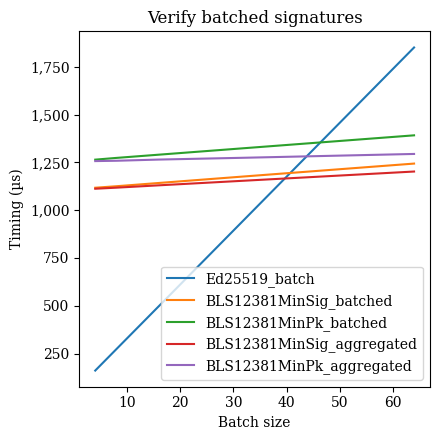

In [23]:
# Plot batch verification
group = "Verify batch"
d = data[group]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

for scheme in d:
    if scheme.startswith("Secp256"):
        continue
    
    x, y, lower_bound, upper_bound = get_series(group, scheme)
    ax.plot(x, y, label = scheme)
    #ax.fill_between(x, lower_bound, upper_bound)

ax.set_title("Verify batched signatures")
ax.legend(loc='lower right')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (µs)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("batch-" + short_commit + ".svg")

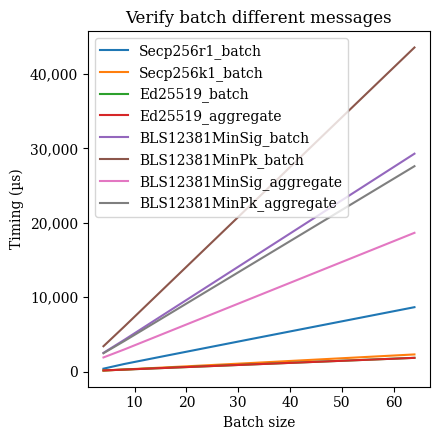

In [13]:
# Plot batch verification different messages
group = "Verify batch different messages"
d = data[group]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

for scheme in d:
    x, y, lower_bound, upper_bound = get_series(group, scheme)
    ax.plot(x, y, label = scheme)
    #ax.fill_between(x, lower_bound, upper_bound)

ax.set_title(group)
ax.legend(loc='upper left')
ax.set_xlabel('Batch size')
ax.set_ylabel('Timing (µs)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("batchdif-" + short_commit + ".svg")

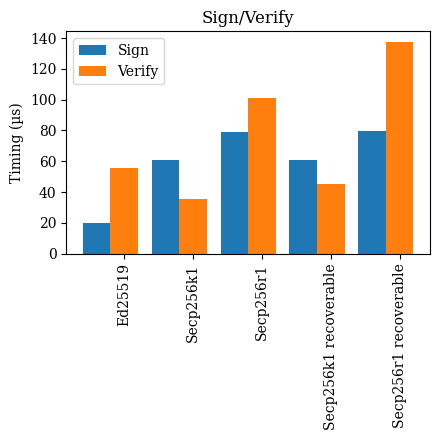

In [24]:
# Plot signing

fig, ax = plt.subplots(figsize=(4.5, 4.5))
width = 0.4

group = "Sign"
d = data[group]

d.pop('BLS12381MinSig')
d.pop('BLS12381MinPk')

schemes, y, lower_bound, upper_bound = get_series(group)
x = np.arange(len(schemes)) - width / 2
ax.bar(x, y, width, label = group)

group = "Verify"
d = data[group]

d.pop('BLS12381MinSig')
d.pop('BLS12381MinPk')

schemes, y, lower_bound, upper_bound = get_series(group)
x = np.arange(len(schemes)) + width / 2
ax.bar(x, y, width, label = group)

ax.set_title("Sign/Verify")
ax.set_ylabel('Timing (µs)')
ax.legend()
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(ymin=0)

ax.set_xticks(x, d.keys());
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("signatures-" + short_commit + ".svg")

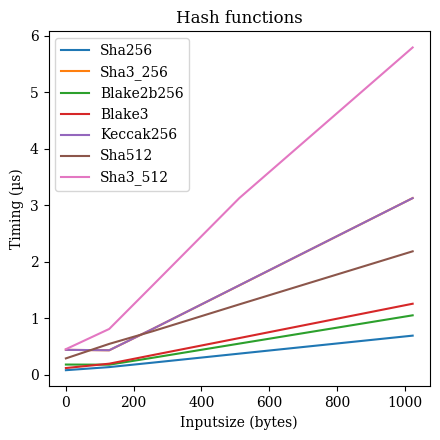

In [26]:
# Plot performance of different hash functions
group = "Hash"
d = data[group]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

for function in d:
    x, y, lower_bound, upper_bound = get_series(group, function)
    ax.plot(x, y, label = function)

ax.set_title("Hash functions")
ax.legend(loc='upper left')
ax.set_xlabel('Inputsize (bytes)')
ax.set_ylabel('Timing (µs)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("hash-" + short_commit + ".svg")

In [27]:
# Plot historic performance of ECDSA verification over Secp256r1

# All commits where benchmark reports have been run
history = ["79ff642ec71ce8ba671483237b25d683b07e045d", 
           "7dc17afca3f9bfcd2a0a712e8cc6da3ad745eb90", 
           "51a2bf654e53c396707fb200f8b3bea2b5c774eb", 
           "375ab9c2494e51cb7bd41157f3431ee0e4b3d784", 
           "4235ea03f3e32db6dd5ef3dff7f86cb88a991f04", 
           "6100b7ae441c65fb5fcc517c13e082352422abbd", 
           "a6e3e8bceed47c3b32de60e3cd13e63c44ab7577", 
           "a13997fb8f87576cf7fe88f26c9238e4a2f6279e", 
           "dd5adb669b895785d3f34abc562fca26c943154a"]

commits = []
performance = []

for commit in history:
    
    data = load_data(commit);
    # Not all commits had Secp256r1
    if 'Verify' in data and 'Secp256r1' in data['Verify']:
        commits.append(commit[0:6])
        performance.append(data['Verify']['Secp256r1']['estimate'] / 1000)
                      
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.plot(commits, performance, label = "Secp256r1")

ax.set_title("ECDSA/Secp256r1 verification")
ax.set_xlabel('Commit')
ax.set_ylabel('Timing (µs)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("secp256r1-history-" + short_commit + ".svg")


TypeError: 'NoneType' object is not subscriptable

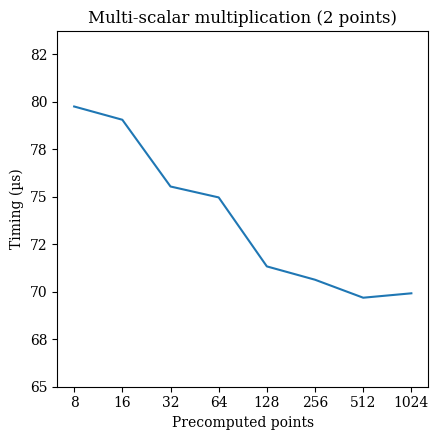

In [16]:
# Plot performance of different hash functions

print

group = 'Double Scalar Multiplication'
#d = data[group]

# Not in latest commit so we hardcode
x = ['8', '16', '32', '64', '128', '256', '512', '1024']
y = [79.756, 79.058, 75.543, 74.968, 71.336, 70.634, 69.687, 69.919]

fig, ax = plt.subplots(figsize=(4.5, 4.5))
width = 0.6

ax.plot(x, y, width, label = group)

ax.set_title("Multi-scalar multiplication (2 points)")
ax.set_ylabel('Timing (µs)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(ymin=65)
ax.set_xlabel('Precomputed points')

plt.tight_layout()
plt.savefig("msm-" + short_commit + ".svg")

In [28]:
# Degressions
limit = 0.20
degressions = dict(filter(lambda c: c[1] > limit, changes.items()))
degressions = dict(sorted(degressions.items(), key=lambda x: -x[1]))
print(json.dumps(degressions, indent=2))

{
  "Hash/Blake3/1024": 0.42253663810371056,
  "Hash/Blake3/512": 0.4132567326803267,
  "Hash/Blake3/256": 0.3690783437164391,
  "Deserialize signature/Secp256k1": 0.3054374984457029,
  "Hash/Blake3/128": 0.28880034792323905,
  "Deserialize signature/Secp256r1": 0.2848235317376733,
  "Deserialize signature/BLS12381MinPk non-compact": 0.2759192293369497,
  "Deserialize signature/Ed25519": 0.26707884951272076,
  "Deserialize signature/BLS12381MinSig non-compact": 0.24959708691756832,
  "Base58 decoding/base58_decode_MSG_64B_RANDOM": 0.24541317183656108,
  "Base58 decoding/base58_decode_MSG_32B_RANDOM": 0.24017611894052937,
  "Base58 decoding/base58_decode_MSG_20B_RANDOM": 0.22095857072916503,
  "Hex encoding/hex_encode_MSG_64B_ZERO": 0.21405823775379962,
  "Deserialize signature/BLS12381MinSig": 0.20142881116744205,
  "Hex encoding/hex_encode_MSG_64B_RANDOM": 0.2005370704184941
}


In [29]:
# Improvements
limit = -0.20
improvements = dict(filter(lambda c: c[1] < limit, changes.items()))
improvements = dict(sorted(improvements.items(), key=lambda x: x[1]))
print(json.dumps(improvements, indent=2))

{
  "Hash/Sha256/512": -0.8673283413190555,
  "Hash/Sha256/1024": -0.8672961783131927,
  "Hash/Sha256/256": -0.8648100283339837,
  "Hash/Sha256/128": -0.8604378954296787,
  "Hash/Sha256/0": -0.7677137879847834,
  "Base58 encoding/rust_base58_encode_MSG_64B_RANDOM": -0.4199600897405624,
  "Base58 encoding/rust_base58_encode_MSG_32B_RANDOM": -0.34707824353776173,
  "Base64 encoding/base64ct_decode_MSG_64B_RANDOM": -0.3046983585592419,
  "Base64 encoding/base64ct_decode_MSG_64B_ZERO": -0.30456621741479517,
  "Base58 decoding/base58_decode_MSG_64B_ZERO": -0.3031943915495513,
  "Base58 decoding/bs58_decode_MSG_20B_ZERO": -0.2981678909900035,
  "Hex encoding/faster_hex_encode_MSG_64B_RANDOM": -0.29467040507862874,
  "Hex decoding/faster_hex_decode_unchecked_MSG_64B_ZERO": -0.2934296548996126,
  "Base64 encoding/radix64_decode_MSG_32B_RANDOM": -0.29336633768930975,
  "Base58 decoding/bs58_decode_MSG_32B_ZERO": -0.2924128556091957,
  "Base58 encoding/rust_base58_encode_MSG_20B_RANDOM": -0.2869